In [20]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import celerite as celery
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
from exoplanet.gp import terms, GP
np.random.seed(13)
%matplotlib inline

In [21]:
data_dir = '/Users/mbedell/python/pmodes/experiments/data/'
import utils

In [22]:
d = np.genfromtxt(data_dir+'sim_oneyear.csv', names=True, dtype=None, delimiter=',')
ts_all = np.copy(d['ts'])
rvs_all = np.copy(d['rvs'])
rvs_noiseless = np.copy(rvs_all)
rvs_all += np.random.normal(0., 1.0, len(rvs_all)) # photon noise - 1 m/s for 1-minute
xs_all = np.copy(d['xs'])

In [23]:
time_per_night = 30. * 60. # seconds
nights_per_year = 60
integrated_kernel = True # for the > 1 minute exposures only
exp_time = 5. * 60. # seconds

In [24]:
start_ts_random = np.random.choice(360, nights_per_year, replace=False) * 3600. * 24. # nightly for random nights (we're gonna ignore seasons)
start_ts_random += np.random.randint(-60, 60, nights_per_year)*60. # random perturbation of up to an hour before/after - can only be whole minutes to avoid interpolation
start_ts_random.sort()
assert np.isin(start_ts_random, ts_all).all(), "Bad timestamp!"

In [25]:
n_exp = int(time_per_night/exp_time)

t = []
y = []

for st in start_ts_random:
    inds = (ts_all > st - 1800.) & (ts_all < st + time_per_night + 1800.)
    for n in range(n_exp):
        stt = st + n*exp_time # start time for this exposure, assumes no read time
        y.append(utils.simulate_exposure(ts_all[inds], rvs_all[inds], stt, exp_time))
        t.append(stt + exp_time/2.)
        
t = np.ravel(t)
y = np.ravel(y)
yerr = np.zeros_like(t) + 1.0 / np.sqrt(exp_time/60.)
t_grid = utils.make_t_grid(start_ts_random, time_per_night)

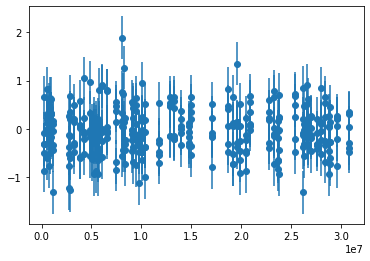

In [27]:
plt.errorbar(t, y, yerr, ls='', marker='o');

Check that our GP should work:

In [28]:
y_pred, mu, sd = utils.gp_predict(t, y, yerr, t_grid, integrated=False, exp_time=exp_time)

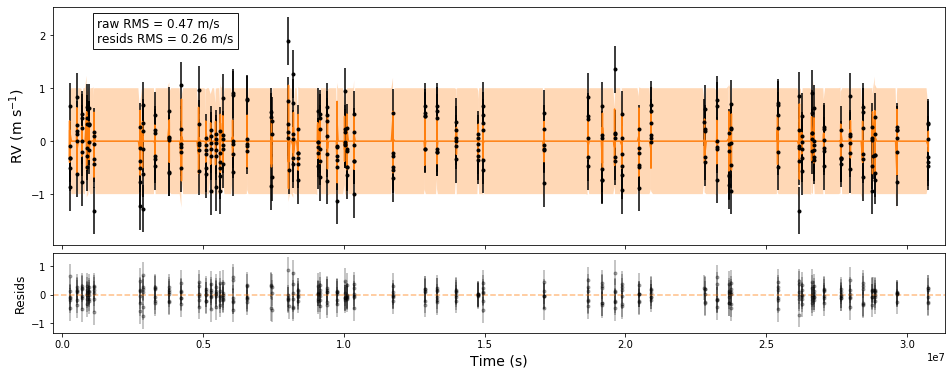

In [29]:
utils.plot_year(t, y, yerr, y_pred, start_ts_random, t_grid, mu, sd);

#### inject a planet:

In [30]:
K = 0.6 # m/s semi-amplitude
P = 100. # days orbital period
ecc = 0.05 # eccentricity
omega = 1.0 # radians periastron arg
t_periastron = 20. # days

In [31]:
days_to_s = 24. * 3600.
s_to_days = 1. / days_to_s

In [32]:
with pm.Model() as model:
    true_orbit = xo.orbits.KeplerianOrbit(period=P, t_periastron=t_periastron, ecc=ecc, omega=omega)
    true_rvs = xo.eval_in_model(true_orbit.get_radial_velocity(t * s_to_days, K=K))
    true_rvs_grid = xo.eval_in_model(true_orbit.get_radial_velocity(t_grid * s_to_days, K=K))

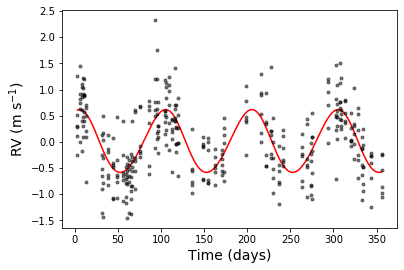

In [33]:
plt.plot(t_grid * s_to_days, true_rvs_grid, 'r-')
plt.plot(t * s_to_days, y+true_rvs, 'k.', alpha=0.5)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel(r'RV (m s$^{-1}$)', fontsize=14);

In [34]:
y += true_rvs

#### try to recover the planet while also modeling GP:

In [35]:
logS0=0.4
logw0=-3.9
logQ=3.5

with pm.Model() as model:
    # orbit model:
    logK = pm.Normal(
        "logK", mu=np.log(0.5), sd=10.0, testval=np.log(0.3))
    
    orbit = xo.orbits.KeplerianOrbit(period=P, t_periastron=t_periastron, ecc=ecc, omega=omega)
    vrad = orbit.get_radial_velocity(t * s_to_days, K=tt.exp(logK))
    pm.Deterministic("vrad", vrad)
    
    # GP model:
    kernel = terms.SHOTerm(log_S0=logS0, log_w0=logw0, log_Q=logQ)
    #kernel_int = terms.IntegratedTerm(kernel, exp_time)
    #gp = GP(kernel_int, t, yerr ** 2)
    gp = GP(kernel, t, yerr ** 2)
    pm.Potential("rv_obs", gp.log_likelihood(y - vrad))
    
    # optimize:
    map_soln = xo.optimize(start=model.test_point)
    mu, var = xo.eval_in_model(gp.predict(t_grid, return_var=True), map_soln)
    sd = np.sqrt(var)
    y_pred = xo.eval_in_model(gp.predict(t) + vrad, point=map_soln)
    y_pred_grid = xo.eval_in_model(gp.predict(t_grid) 
                                   + orbit.get_radial_velocity(t_grid * s_to_days, K=tt.exp(logK)), 
                                   point=map_soln)
    
    pl_resids = y - xo.eval_in_model(vrad, point=map_soln)
    y_pred_resids = y_pred - xo.eval_in_model(vrad, point=map_soln)
    
    trace = pm.sample(draws=2000, tune=8000)

optimizing logp for variables: [logK]
12it [00:00, 165.00it/s, logp=-3.382316e+02] 
message: Optimization terminated successfully.
logp: -340.38532431281385 -> -338.2315514423111
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logK]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:07<00:00, 5605.93draws/s]
The acceptance probability does not match the target. It is 0.9262911737444358, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.695643277012003, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9215323461708909, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


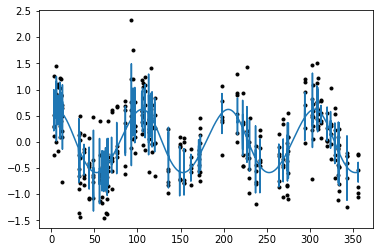

In [36]:
plt.plot(t * s_to_days, y, 'k.')
plt.plot(t_grid * s_to_days, y_pred_grid);

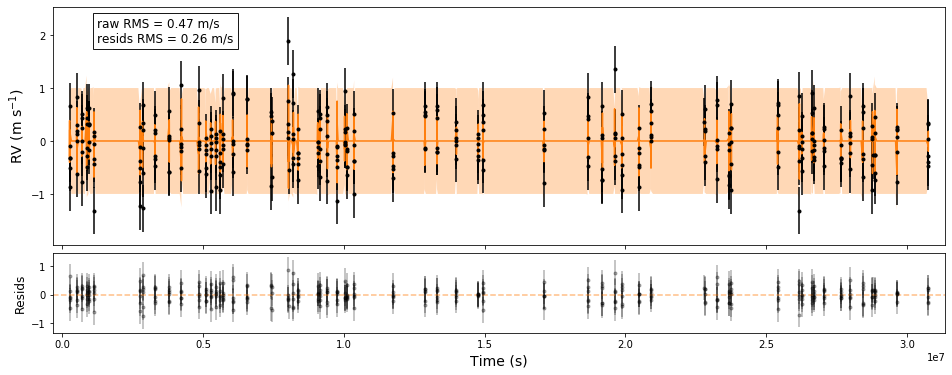

In [37]:
utils.plot_year(t, pl_resids, yerr, y_pred_resids, start_ts_random, t_grid, mu, sd);

In [38]:
with pm.Model() as model_nogp:
    # orbit model:
    logK = pm.Normal(
        "logK", mu=np.log(0.5), sd=10.0, testval=np.log(0.3))
    
    orbit = xo.orbits.KeplerianOrbit(period=P, t_periastron=t_periastron, ecc=ecc, omega=omega)
    vrad = orbit.get_radial_velocity(t * s_to_days, K=tt.exp(logK))
    
    rv_model = pm.Deterministic("rv_model", vrad) 
    pm.Normal("obs", mu=rv_model, sd=yerr, observed=y)
    
    # optimize:
    map_soln_nogp = xo.optimize(start=model_nogp.test_point)
    y_pred_nogp = xo.eval_in_model(vrad, point=map_soln_nogp)
    y_pred_grid_nogp = xo.eval_in_model(orbit.get_radial_velocity(t_grid * s_to_days, K=tt.exp(logK)), 
                                   point=map_soln_nogp)
    
    trace_nogp = pm.sample(draws=2000, tune=8000)

optimizing logp for variables: [logK]
13it [00:00, 247.17it/s, logp=-2.455235e+02] 
message: Optimization terminated successfully.
logp: -295.5664551860611 -> -245.52351051618305
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logK]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:06<00:00, 6105.36draws/s]


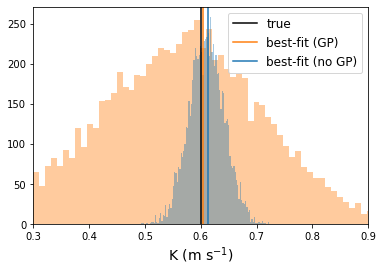

In [39]:
plt.hist(np.exp(trace["logK"]), color='C1', alpha=0.4, bins=100)
plt.hist(np.exp(trace_nogp["logK"]), color='C0', alpha=0.4, bins=100)
plt.axvline(K, label='true', c='k')
plt.axvline(np.exp(map_soln['logK']), c='C1', label='best-fit (GP)')
plt.axvline(np.exp(map_soln_nogp['logK']), c='C0', label='best-fit (no GP)')
plt.legend(fontsize=12)
plt.xlabel(r'K (m s$^{-1}$)', fontsize=14)
plt.xlim([K*0.5,K*1.5]);